# Product POMDP and MDP with Automata

In [1]:
using Revise
using Random
using POMDPs
# using POMDPModels
using POMDPModelTools
using POMDPPolicies
using POMDPSimulators
using POMDPModelChecking
using BeliefUpdaters
using Spot
# using DiscreteValueIteration
includet("../test/blind_gridworld.jl")

┌ Info: Precompiling POMDPSimulators [e0d0a172-29c6-5d4e-96d0-f262df5d01fd]
└ @ Base loading.jl:1186
┌ Info: Precompiling POMDPModelChecking [abefb91b-a28c-5ab9-9bd9-026e532d7b0e]
└ @ Base loading.jl:1186
┌ Info: Precompiling LightGraphs [093fc24a-ae57-5d10-9952-331d41423f4d]
└ @ Base loading.jl:1186
┌ Info: Precompiling Spot [f11abc24-ce50-11e8-2475-af6658d13f2b]
└ @ Base loading.jl:1186


LoadError: InitError: type PyObject has no field path
during initialization of module Spot

## Task and environment

In [3]:
property =  ltl"(!c U a) & (!c U b)";

LoadError: UndefVarError: @ltl_str not defined

In [4]:
a = translate(LTLTranslator(buchi=true, deterministic=true, state_based_acceptance=true), property)
spot.to_generalized_rabin(a)

UndefVarError: UndefVarError: LTLTranslator not defined

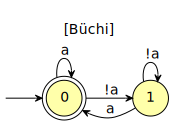

In [15]:
property = ltl"G F a"
a = translate(LTLTranslator(buchi=false, deterministic=true, state_based_acceptance=true), property)

In [4]:
mdp = SimpleGridWorld(size=(10,10), terminate_from=Set([]), tprob=0.7);

const LABELLED_STATES = Dict(GWPos(3,7) => :a, GWPos(8,5) => :b, GWPos(4,3) => :c)

function POMDPModelChecking.labels(mdp::SimpleGridWorld, s, a)
    if haskey(LABELLED_STATES, s)
        return tuple(LABELLED_STATES[s])
    else
        return ()
    end
end

solver = ModelCheckingSolver(property = ltl"(!c U a) & (!c U b)", solver=ValueIterationSolver(verbose=false))
policy = solve(solver, mdp);

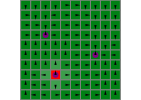

In [5]:
POMDPModelChecking.reset_memory!(policy)
ctx = POMDPModels.render(mdp, Dict(), valuecolor=s -> value(policy, s),
                         action = s -> begin 
                                         a = action(policy, s)
                                         POMDPModelChecking.reset_memory!(policy)
                                         return a
                                       end,
                         landmark = s -> s ∈ keys(LABELLED_STATES))

## Partially Observable GridWorld

In [9]:
using QMDP
using FIB
using SARSOP

┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/FIB/05WTx.ji for FIB [13b007ba-0ca8-5af2-9adf-bc6a6301e25a]
└ @ Base loading.jl:1190


In [11]:
pomdp = BlindGridWorld(size=(10,10), exit=GWPos(4,3), 
                       simple_gw=SimpleGridWorld(size=(10,10), terminate_from=Set([])));
POMDPModelChecking.labels(pomdp::BlindGridWorld, s, a) = labels(pomdp.simple_gw, s, a)

#XXX Hack
γ = 1 - 1e-4
POMDPs.discount(::ProductPOMDP) = γ

solver = ModelCheckingSolver(property = ltl"(!c U a) & (!c U b)", 
#               solver=SARSOPSolver(precision=1e-3, timeout=15.0, verbose=true)
              solver = QMDPSolver(tolerance=1e-3, verbose=true)
#               solver = FIBSolver(tolerance=1e-3, verbose=true)
)
policy = solve(solver, pomdp);

InterruptException: InterruptException:

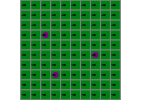

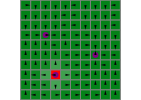

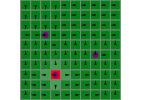

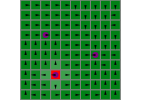

In [8]:
policy.memory = 1
ctx1 = POMDPModels.render(mdp, Dict(), valuecolor=s->value(policy.policy, deterministic_belief(policy.problem, ProductState(s, policy.memory))), 
                                      action=s->action(policy.policy, deterministic_belief(policy.problem, ProductState(s, policy.memory))), 
                                      landmark = s -> s ∈ keys(LABELLED_STATES))
policy.memory = 2
ctx2 = POMDPModels.render(mdp, Dict(), valuecolor=s->value(policy.policy, deterministic_belief(policy.problem, ProductState(s, policy.memory))), 
                                      action=s->action(policy.policy, deterministic_belief(policy.problem, ProductState(s, policy.memory))), 
                                      landmark = s -> s ∈ keys(LABELLED_STATES))
policy.memory = 3
ctx3 = POMDPModels.render(mdp, Dict(), valuecolor=s->value(policy.policy, deterministic_belief(policy.problem, ProductState(s, policy.memory))), 
                                      action=s->action(policy.policy, deterministic_belief(policy.problem, ProductState(s, policy.memory))), 
                                      landmark = s -> s ∈ keys(LABELLED_STATES))
policy.memory = 4
ctx4 = POMDPModels.render(mdp, Dict(), valuecolor=s->value(policy.policy, deterministic_belief(policy.problem, ProductState(s, policy.memory))), 
                                      action=s->action(policy.policy, deterministic_belief(policy.problem, ProductState(s, policy.memory))), 
                                      landmark = s -> s ∈ keys(LABELLED_STATES))
display(ctx1)
display(ctx2)
display(ctx3)
display(ctx4)

## Evaluate Policy

In [9]:
using ProgressMeter


In [87]:
succ, fail, steps = evaluation(mdp, policy, 1000, 200)
println("Successes: $succ | Failures: $fail | avg steps $steps")

MethodError: MethodError: no method matching action(::AlphaVectorPolicy{ProductPOMDP{SArray{Tuple{2},Int64,1,2},Symbol,SArray{Tuple{2},Int64,1,2},Int64,DeterministicRabinAutomata},Symbol}, ::SArray{Tuple{2},Int64,1,2})
Closest candidates are:
  action(!Matched::FeedWhenCrying, ::Any) at /mnt/c/Users/Maxime/wsl/.julia/packages/POMDPModels/uUOPJ/src/CryingBabies.jl:91
  action(!Matched::Starve, ::B) where B at /mnt/c/Users/Maxime/wsl/.julia/packages/POMDPModels/uUOPJ/src/CryingBabies.jl:71
  action(!Matched::AlwaysFeed, ::B) where B at /mnt/c/Users/Maxime/wsl/.julia/packages/POMDPModels/uUOPJ/src/CryingBabies.jl:75
  ...

In [86]:
function evaluation(mdp, policy::ModelCheckingPolicy, n_ep=100, max_steps=100, rng=MersenneTwister(1))
    succ = 0
    fail = 0
    steps = 0
    @showprogress for ep=1:n_ep
        POMDPModelChecking.reset_memory!(policy)
        s = initialstate(mdp, rng)
        step = 0
        done = false
        while step <= max_steps && !done
            a = action(policy, s)
            sp, r = generate_sr(mdp, s, a, rng)
           
            if s == GWPos(4, 3)
                fail += 1
                done = true
                steps += step
#                 println(" FAIL ")
            elseif policy.memory == 1
                succ += 1 
                steps += step
#                 println(" SUCCESS ")
                done = true 
            end
            step += 1
            s = sp
        end
    end
    return succ, fail, steps/n_ep
end

evaluation (generic function with 8 methods)

In [11]:
# b0 = initialstate_distribution(policy.problem)
b0 = deterministic_belief(policy.problem, ProductState(GWPos(1,10), 2))
up = DiscreteUpdater(policy.problem)
rng = MersenneTwister(1)
hr = HistoryRecorder(rng=rng, max_steps=100)
# @show s0 = initialstate(pomdp, rng)
s0 = GWPos(1, 10)
hist = simulate(hr, pomdp, policy, up, b0, s0)
hsab = collect(eachstep(hist, "s, a, b, o, sp"))
for step=1:n_steps(hist)
    s, a, b, o, sp = hsab[step]
    @show s
    @show a 
    @show sp
    @show labels(mdp, s, a)
#     POMDPModels.render(mdp, Dict(:s=>s), color=s->value(policy, s))
end

s0 = initialstate(pomdp, rng) = [3, 8]


ErrorException: Failed discrete belief update: new probabilities sum to zero.

b = DiscreteBelief{ProductPOMDP{SArray{Tuple{2},Int64,1,2},Symbol,SArray{Tuple{2},Int64,1,2},Int64,DeterministicRabinAutomata},ProductState{SArray{Tuple{2},Int64,1,2},Int64}}(ProductPOMDP{SArray{Tuple{2},Int64,1,2},Symbol,SArray{Tuple{2},Int64,1,2},Int64,DeterministicRabinAutomata}(BlindGridWorld
  size: Tuple{Int64,Int64}
  exit: SArray{Tuple{2},Int64,1,2}
  simple_gw: SimpleGridWorld
, DeterministicRabinAutomata(2, 1:4, {4, 9} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), Symbol[:c, :a, :b], Tuple{Set{Int64},Set{Int64}}[(Set([]), Set([1]))]), Set(ProductState{SArray{Tuple{2},Int64,1,2},Int64}[ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 1)]), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], -1)), ProductState{SArray{Tuple{2},Int64,1,2},Int64}[ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], -1)], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.83132, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16868, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
a = down
o = [1, 7]

Failed discrete belief update: new probabilities sum to zero.


In [16]:
function evaluation(pomdp, up::DiscreteUpdater, policy::ModelCheckingPolicy, n_ep=100, max_steps=100, rng=MersenneTwister(2))
    succ = 0
    fail = 0
    steps = 0
    @showprogress for ep=1:n_ep
#         b = deterministic_belief(policy.problem, ProductState(GWPos(1, 10), 2))
#         s = GWPos(1,10)
        b = initialstate_distribution(policy.problem)
        s = initialstate(pomdp, rng)
        step = 0
        done = false
        hasvisited = false
        while step <= max_steps && !done
            a = action(policy, b)
            sp, o, r= generate_sor(pomdp, s, a, rng)
#             println("step $step $sp $(labels(pomdp, sp, a))")
            bp = update(up, b, a, o)
#             bp = try
#                 bp = update(up, b, a, o)
#             catch
#                 println(states(policy.problem)[findall(b.b .> 0)])
#                 next_states = []
#                 for ss in states(policy.problem)[findall(b.b .> 0)]
#                     d = transition(policy.problem, ss, action(policy, b))
#                     push!.(Ref(next_states), support(d))
#                 end
#                 println(" next states :")
#                 for ss in next_states
#                     println(ss)
#                 end
#                 throw("belief crash: obs ", o, " action ", a, " sp ", sp)
#             end
            
            if s == GWPos(4, 3)
                fail += 1
                done = true
                steps += step
                println("$ep FAIL ")
            elseif s == GWPos(8,5) && hasvisited || (s == GWPos(3,7) && hasvisited)
                succ += 1 
                steps += step
                println("$ep SUCCESS ")
                done = true 
            elseif step == 100
                println("$ep TIME OUT")
            end
            
            if s == GWPos(8,5) || s == GWPos(3,7)
                hasvisited = true
            end
            step += 1
            b = bp
            s = sp
        end
    end
    return succ, fail, steps/n_ep
end

evaluation (generic function with 4 methods)

In [17]:
up = DiscreteUpdater(policy.problem)
succ, fail, steps = evaluation(pomdp, up, policy, 100, 300)
println("Successes: $succ | Failures: $fail | avg steps $steps")

1 SUCCESS 


Progress:   1%|                                         |  ETA: 6:00:50

2 SUCCESS 


Progress:   3%|█                                        |  ETA: 6:04:41

4 SUCCESS 


Progress:   4%|██                                       |  ETA: 5:26:28

5 FAIL 


Progress:   5%|██                                       |  ETA: 4:19:17

6 SUCCESS 


Progress:   6%|██                                       |  ETA: 4:38:06

7 SUCCESS 


Progress:   7%|███                                      |  ETA: 4:28:21

8 SUCCESS 


Progress:   8%|███                                      |  ETA: 3:53:07

9 SUCCESS 


Progress:   9%|████                                     |  ETA: 3:58:26

10 SUCCESS 


Progress:  10%|████                                     |  ETA: 3:42:16

11 SUCCESS 


Progress:  11%|█████                                    |  ETA: 3:40:14

12 SUCCESS 


Progress:  12%|█████                                    |  ETA: 3:27:50

13 SUCCESS 


Progress:  13%|█████                                    |  ETA: 3:18:27

14 SUCCESS 


Progress:  14%|██████                                   |  ETA: 3:09:22

15 SUCCESS 


Progress:  15%|██████                                   |  ETA: 3:06:44

16 FAIL 


Progress:  16%|███████                                  |  ETA: 2:59:53

17 FAIL 


Progress:  17%|███████                                  |  ETA: 2:47:22

18 SUCCESS 


Progress:  18%|███████                                  |  ETA: 2:45:45

19 SUCCESS 


Progress:  19%|████████                                 |  ETA: 2:40:45

20 SUCCESS 


Progress:  20%|████████                                 |  ETA: 2:43:18

21 SUCCESS 


Progress:  21%|█████████                                |  ETA: 2:41:00

22 SUCCESS 


Progress:  22%|█████████                                |  ETA: 2:36:17

23 SUCCESS 


Progress:  23%|█████████                                |  ETA: 2:37:00

24 SUCCESS 


Progress:  24%|██████████                               |  ETA: 2:31:06

25 SUCCESS 


Progress:  25%|██████████                               |  ETA: 2:27:04

26 SUCCESS 


Progress:  26%|███████████                              |  ETA: 2:21:54

27 SUCCESS 


Progress:  27%|███████████                              |  ETA: 2:21:09

28 SUCCESS 


Progress:  28%|███████████                              |  ETA: 2:20:55

29 SUCCESS 


Progress:  29%|████████████                             |  ETA: 2:24:32

30 SUCCESS 


Progress:  30%|████████████                             |  ETA: 2:21:36

31 SUCCESS 


Progress:  31%|█████████████                            |  ETA: 2:22:43

32 SUCCESS 


Progress:  32%|█████████████                            |  ETA: 2:26:03

33 SUCCESS 


Progress:  33%|██████████████                           |  ETA: 2:30:30

34 SUCCESS 


Progress:  34%|██████████████                           |  ETA: 2:34:11

35 SUCCESS 


Progress:  35%|██████████████                           |  ETA: 2:33:31

36 SUCCESS 


Progress:  36%|███████████████                          |  ETA: 2:30:23

37 SUCCESS 


Progress:  37%|███████████████                          |  ETA: 2:28:45

38 FAIL 


Progress:  38%|████████████████                         |  ETA: 2:31:31

39 SUCCESS 


Progress:  39%|████████████████                         |  ETA: 2:30:49

40 SUCCESS 


Progress:  40%|████████████████                         |  ETA: 2:27:09

41 SUCCESS 


Progress:  41%|█████████████████                        |  ETA: 2:24:56

InterruptException: InterruptException:

In [62]:
value(policy, deterministic_belief(policy.problem, ProductState(GWPos(1,10), 2)))

0.844108

In [313]:
b = bp
s = sp;

a = action(policy, b) = :left
(sp, o, r) = generate_sor(pomdp, s, a, rng) = ([7, 5], [7, 6], 0.0)
  0.095423 seconds (703.60 k allocations: 39.759 MiB, 10.19% gc time)


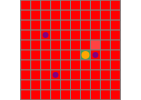

In [314]:
@show a = action(policy, b)
@show sp, o, r = generate_sor(pomdp, s, a, rng)
@time bp = update(up, b, a, o)
render(mdp, Dict(:s=>sp), valuecolor = s-> sum(pdf(bp, ProductState(s,q)) for q=1:4), landmark = s -> s ∈ keys(LABELLED_STATES))

In [315]:
states(policy.problem)[findall(bp.b .> 0)]

2-element Array{ProductState{SArray{Tuple{2},Int64,1,2},Int64},1}:
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 1)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 1)

In [316]:
@show l = labels(pomdp, GWPos(3,7), action)
@show qp = nextstate(policy.problem.automata, 3, l)

l = labels(pomdp, GWPos(3, 7), action) = (:a,)
qp = nextstate((policy.problem).automata, 3, l) = 1


1

In [317]:
next_states = []
for s in states(policy.problem)[findall(bp.b .> 0)]
    d = transition(policy.problem, s, action(policy, bp))
    push!.(Ref(next_states), support(d))
end
next_states

2-element Array{Any,1}:
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], -1)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], -1)

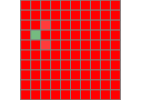

In [92]:
render(mdp, Dict(), valuecolor = s-> sum(pdf(b, ProductState(s,q)) for q=1:4))

In [193]:
using LightGraphs
using MetaGraphs

In [197]:
dra = policy.problem.automata
dra.transition
q = 3
lab = (:a,)
@show next_states = neighbors(dra.transition, q)
edge_it = filter_edges(dra.transition, (g, e) -> (src(e) == q) && (lab ∈ props(g, e)[:cond]))
edge_list = collect(edge_it)

next_states = neighbors(dra.transition, q) = [1, 3]


1-element Array{LightGraphs.SimpleGraphs.SimpleEdge{Int64},1}:
 Edge 3 => 1

In [13]:
@show s0 = initialstate(pomdp, rng)
sp, o, r = generate_sor(pomdp, s0, :up, rng)
update(up, b0, :up, o)

s0 = initialstate(pomdp, rng) = [1, 6]


DiscreteBelief{ProductPOMDP{SArray{Tuple{2},Int64,1,2},Symbol,SArray{Tuple{2},Int64,1,2},Int64,DeterministicRabinAutomata},ProductState{SArray{Tuple{2},Int64,1,2},Int64}}(ProductPOMDP{SArray{Tuple{2},Int64,1,2},Symbol,SArray{Tuple{2},Int64,1,2},Int64,DeterministicRabinAutomata}(BlindGridWorld
  size: Tuple{Int64,Int64}
  exit: SArray{Tuple{2},Int64,1,2}
  simple_gw: SimpleGridWorld
, DeterministicRabinAutomata(2, 1:4, {4, 9} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), Symbol[:c, :a, :b], Tuple{Set{Int64},Set{Int64}}[(Set([]), Set([1]))]), Set(ProductState{SArray{Tuple{2},Int64,1,2},Int64}[ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 1), Produc

In [11]:
function runsim(pomdp::BlindGridWorld, policy::ModelCheckingPolicy, n_ep=100, max_steps=100)
    b0 = deterministic_belief(policy.problem, ProductState(GWPos(1, 10), 3))
    up = DiscreteUpdater(policy.problem)
    s0 = GWPos(1, 10)
    sim = RolloutSimulator(max_steps=max_steps)
    r_tot = 0.
    @showprogress for ep=1:n_ep
        r_tot += simulate(sim, pomdp, policy, up, b0, s0)
    end
    return r_tot
end
    

LoadError: UndefVarError: @showprogress not defined

In [12]:

function POMDPs.update(bu::DiscreteUpdater, b::SparseCat, a::Symbol, o)
    println("hello")
    pomdp = bu.pomdp
    state_space = states(pomdp)
    bp = zeros(length(state_space))

    bp_sum = 0.0   # to normalize the distribution

    for (spi, sp) in enumerate(state_space)

        # po = O(a, sp, o)
        od = observation(pomdp, a, sp)
        po = pdf(od, o)

        if po == 0.0
            continue
        end

        b_sum = 0.0   
        for (s, prob) in weighted_iterator(b)
            td = transition(pomdp, s, a) 
            pp = pdf(td, sp)
            b_sum += pp * prob
        end

        bp[spi] = po * b_sum
        bp_sum += bp[spi]
    end

    if bp_sum == 0.0
        error("""
              Failed discrete belief update: new probabilities sum to zero.
              b = $b
              a = $a
              o = $o
              Failed discrete belief update: new probabilities sum to zero.
              """)
    else
        for i = 1:length(bp); bp[i] /= bp_sum; end
    end

    return SparseCat{Vector{statetype(pomdp)}, Vector{Float64}}(state_sppace[bp > 0.], bp[bp > 0.])
end


In [48]:
using Plots

┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


In [11]:
using Reel
speed_factor = 2
duration = n_steps(hist) / speed_factor
fps = speed_factor
film = roll(fps=fps, duration=duration) do t, dt
    frame_idx = Int(t/dt) + 1
    s, a, b, sp = hsab[frame_idx]
    POMDPModels.render(mdp, Dict(:s=>s), valuecolor=s->0.5,  landmark = s -> s ∈ keys(LABELLED_STATES))
end


┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/Reel/Y4fsG.ji for Reel [71555da5-176e-5e73-a222-aebc6c6e4f2f]
└ @ Base loading.jl:1190


Frames{MIME{Symbol("text/html")}}("/tmp/tmp5Qh7tZ", 0x0000000000000032, 2.0, nothing)

In [14]:
display(film)

Frames{MIME{Symbol("text/html")}}("/tmp/tmp5Qh7tZ", 0x0000000000000032, 2.0, nothing)

In [18]:
using ProfileView
using Profile

In [33]:
Profile.clear()
@profile update(up, b0, :up, false)
@time update(up, b0, :up, false)

  1.536302 seconds (10.56 M allocations: 524.987 MiB, 13.19% gc time)


DiscreteBelief{ProductPOMDP{SArray{Tuple{2},Int64,1,2},Symbol,Bool,Int64,DeterministicRabinAutomata},ProductState{SArray{Tuple{2},Int64,1,2},Int64}}(ProductPOMDP{SArray{Tuple{2},Int64,1,2},Symbol,Bool,Int64,DeterministicRabinAutomata}(BlindGridWorld
  size: Tuple{Int64,Int64}
  exit: SArray{Tuple{2},Int64,1,2}
  simple_gw: SimpleGridWorld
, DeterministicRabinAutomata(2, 1:4, {4, 9} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), Symbol[:c, :a, :b], Tuple{Set{Int64},Set{Int64}}[(Set([]), Set([1]))]), Set(ProductState{SArray{Tuple{2},Int64,1,2},Int64}[ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10

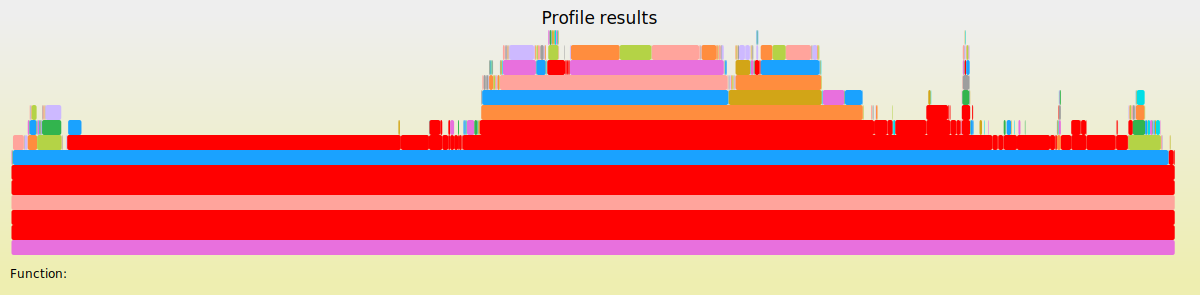

In [21]:
ProfileView.view()

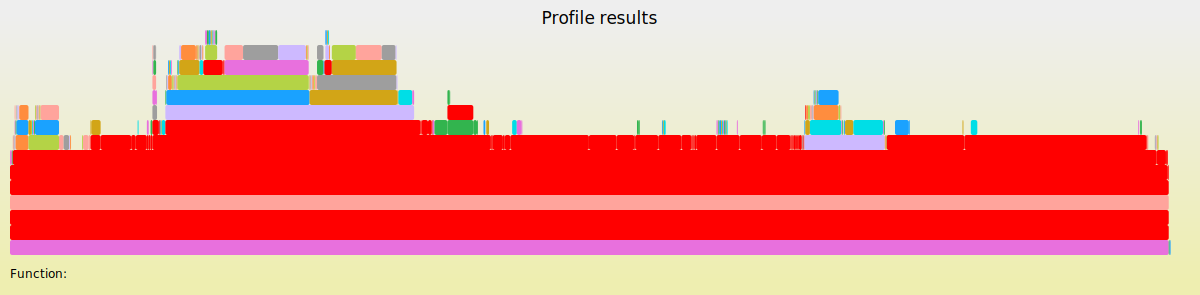

In [27]:
ProfileView.view()

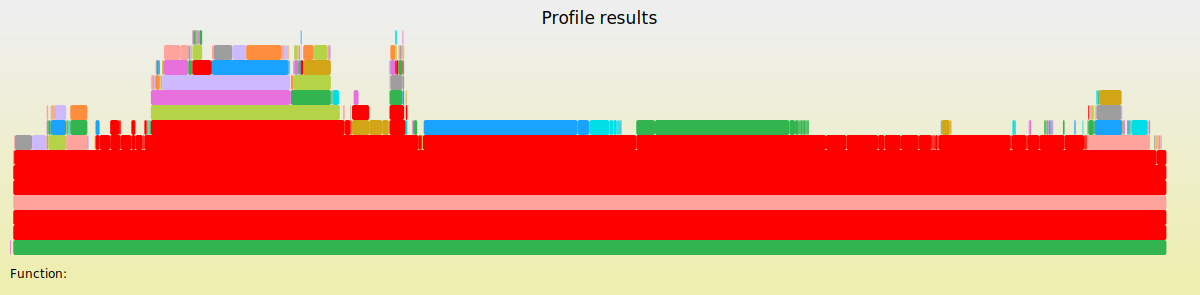

In [31]:
ProfileView.view()

In [13]:
using Interact
hr = HistoryRecorder(rng=MersenneTwister(1), max_steps=50)
s0 = GWPos(1,10)
hist = simulate(hr, pomdp, policy, up, b0, s0)
hsab = collect(eachstep(hist, "s, a, b, sp"))
@manipulate for step=1:n_steps(hist)
    s, a, b, sp = hsab[step]
    POMDPModels.render(mdp, Dict(:s=>s), valuecolor=s->0.5,  landmark = s -> s ∈ keys(LABELLED_STATES))
#     @printf("action: %s, observation: %s\n", a, o)
end

┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/Interact/XmYW4.ji for Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1190


HTML{String}("    <script id=\"webio-setup-2791629777928978018\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-4088565286777260363\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-2791629777928978018\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/8715ecfbd47aa7de81077aaf96f3df24defcde18-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/8715ecfbd47aa7de81077aaf96f3df24defcde18-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-4088565286777260363\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:step=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
25), Observable{Int64} with 2 listeners. Value:
25, Scope("knockout-component-18ab4697-b42e-44ed-a5ed-163793127bb9", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["step"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>50,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Any["knockout"=>"/mnt/c/Users/Maxime/wsl/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/mnt/c/Users/Maxime/wsl/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/mnt/c/Users/Maxime/wsl/.julia/packages/InteractBase/Q4IkI/src/../assets/all.js", "/mnt/c/Users/Maxime/wsl/.julia/packages/InteractBase/Q4IkI/src/../assets/style.css", "/mnt/c/Users/Maxime/wsl/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":25}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (_webIOScope.setObservableValue({\"name\":\"changes\",\"scope\":\"knockout-component-18ab4697-b42e-44ed-a5ed-163793127bb9\",\"id\":\"ob_02\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (_webIOScope.setObservableValue({\"name\":\"value\",\"scope\":\"knockout-component-18ab4697-b42e-44ed-a5ed-163793127bb9\",\"id\":\"ob_01\",\"type\"

In [17]:
@time update(up, b0, :up, false);

  2.463314 seconds (12.40 M allocations: 1.014 GiB, 11.90% gc time)


In [14]:
@manipulate for step=1:n_steps(hist)
    s, a, b, sp = hsab[step]
    POMDPModels.render(mdp, Dict(:s=>s), valuecolor=s->0.5,  landmark = s -> s ∈ keys(LABELLED_STATES))
#     @printf("action: %s, observation: %s\n", a, o)
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:step=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
25), Observable{Int64} with 2 listeners. Value:
25, Scope("knockout-component-c98c0e19-bd27-40e1-ba65-dd69275bc7c3", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["step"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>50,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Any["knockout"=>"/mnt/c/Users/Maxime/wsl/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/mnt/c/Users/Maxime/wsl/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/mnt/c/Users/Maxime/wsl/.julia/packages/InteractBase/Q4IkI/src/../assets/all.js", "/mnt/c/Users/Maxime/wsl/.julia/packages/InteractBase/Q4IkI/src/../assets/style.css", "/mnt/c/Users/Maxime/wsl/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":25}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (_webIOScope.setObservableValue({\"name\":\"changes\",\"scope\":\"knockout-component-c98c0e19-bd27-40e1-ba65-dd69275bc7c3\",\"id\":\"ob_09\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (_webIOScope.setObservableValue({\"name\":\"value\",\"scope\":\"knockout-component-c98c0e19-bd27-40e1-ba65-dd69275bc7c3\",\"id\":\"ob_08\",\"type\"

## Belief State Solver

In [ ]:
using POMDPModels
using POMDPTesting 
using POMDPSimulators
using GridInterpolations
using Distributions
using LocalApproximationValueIteration
using LocalFunctionApproximation
using SARSOP
using NearestNeighbors
using StaticArrays

const N_BELIEF_POINTS = 20
includet("/mnt/c/Users/Maxime/OneDrive - Leland Stanford Junior University/Research/BeliefStateMDP/BeliefStateMDP.jl")

In [ ]:
bmdp = BeliefStateMDP(policy.problem, DiscreteUpdater(policy.problem))
rng = MersenneTwister(2)
# beliefs = gridworld_belief_discretization(policy.problem, N_BELIEF_POINTS, rng);

In [ ]:
beliefs = [deterministic_belief(policy.problem, s) for s in states(policy.problem)]
vec_b = [convert_s(Vector{Float64}, b, bmdp) for b in beliefs]
nntree = KDTree(vec_b)
k = 10                                                                      # the k parameter for knn approximator
knnfa = LocalNNFunctionApproximator(nntree, vec_b, k)
solver = LocalApproximationValueIterationSolver(knnfa, verbose=true);
# npts = 10
# grid = RectangleGrid(LinRange(0.,1., npts), LinRange(0.,1.,npts))      # rectangular grid
# gifa = LocalGIFunctionApproximator(grid)  # c
# solver = LocalApproximationValueIterationSolver(gifa, verbose=true, max_iterations=30)

In [ ]:
belief_policy = solve(solver, bmdp)

In [ ]:
belief_policy = solve(solver, bmdp)

In [340]:
pt = first(vec_b)
ss = POMDPs.convert_s(statetype(bmdp),pt,bmdp)
dist = transition(bmdp, ss, first(actions(bmdp)))

ErrorException: Failed discrete belief update: new probabilities sum to zero.

b = DiscreteBelief{ProductPOMDP{SArray{Tuple{2},Int64,1,2},Symbol,SArray{Tuple{2},Int64,1,2},Int64,DeterministicRabinAutomata},ProductState{SArray{Tuple{2},Int64,1,2},Int64}}(ProductPOMDP{SArray{Tuple{2},Int64,1,2},Symbol,SArray{Tuple{2},Int64,1,2},Int64,DeterministicRabinAutomata}(BlindGridWorld
  size: Tuple{Int64,Int64}
  exit: SArray{Tuple{2},Int64,1,2}
  simple_gw: SimpleGridWorld
, DeterministicRabinAutomata(2, 1:4, {4, 9} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), Symbol[:c, :a, :b], Tuple{Set{Int64},Set{Int64}}[(Set([]), Set([1]))]), Set(ProductState{SArray{Tuple{2},Int64,1,2},Int64}[ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 1)]), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], -1)), ProductState{SArray{Tuple{2},Int64,1,2},Int64}[ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 2], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 3], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 4], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 5], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 7], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 8], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 9], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([5, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([9, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([10, 10], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 2), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 3), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], 4), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], -1)], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111111, 0.0, 0.0, 0.0, 0.111111, 0.0, 0.0, 0.0, 0.111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111111, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0111111, 0.0, 0.111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0111111, 0.0, 0.111111, 0.0, 0.0, 0.0, 0.0333333, 0.0, 0.0777778, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
a = up
o = [1, 1]

Failed discrete belief update: new probabilities sum to zero.


In [342]:
states(policy.problem)[findall(ss.b .> 0)]

12-element Array{ProductState{SArray{Tuple{2},Int64,1,2},Int64},1}:
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 2)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 5], 2)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 5], 2)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 6], 2)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 2)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 6], 4)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 6], 2)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 2)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 4)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([3, 7], 2)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 2)
 ProductState{SArray{Tuple{2},Int64,1,2},Int64}([4, 7], 4)

In [349]:
transition(bmdp, ss, :up)

InterruptException: InterruptException:

In [11]:
function gridworld_belief_discretization(pomdp::ProductPOMDP, n_beliefs::Int64, rng::AbstractRNG)
    beliefs = Set(DiscreteBelief[])
    policy = RandomPolicy(pomdp)
    up = DiscreteUpdater(pomdp)
    b0 = initialize_belief(up, initialstate_distribution(pomdp))
    push!(beliefs, b0)
    b = b0
    s = initialstate(pomdp, rng)
    while length(beliefs) < n_beliefs
        a = action(policy, b)
        sp, o, r = generate_sor(pomdp, s, a, rng)
        bp = update(up, b, a, o)
        push!(beliefs, bp)
        if isterminal(pomdp, bp)
            b = initialize_belief(up, initialstate_distribution(pomdp))
            s = initialstate(pomdp, rng)
        else
            s = sp
            b = bp
        end
    end
    return beliefs
end

# struct BeliefTransition{M}
#     b::DiscreteBelief
#     mdp::M
# end    

# function POMDPs.transition(mdp::BeliefStateMDP, b, a)
#     return BeliefTransition(mdp)
# end

# function Distributions.pdf(d::BeliefTransition, bp::DiscreteBelief)

# function POMDPs.transition(mdp::BeliefStateMDP, b, a)
#     bp = Vector{DiscreteBelief}()
#     sizehint!(bp, n_observations(mdp.pomdp))
#     probs = Vector{Float64}()
#     sizehint!(probs, n_observations(mdp.pomdp))
#     for (i, o) in enumerate(ordered_observations(mdp.pomdp))
#         if sum(pdf(observation(mdp.pomdp, a, sp), o) for sp in reach(b)) != 0.
#             push!(bp, update(mdp.up, b, a, o))
#             push!(probs, belief_transition_probability(mdp, bp[end], a, o, b))
#         end
#     end
#     return SparseCat(bp, probs)
# end

# function reach_o(b::DiscreteBelief)
#     next_obs = []
#     for s in states(b.pomdp)[findall(b.b .> 0)]
#         for a in actions(b.pomdp)
#             d = transition(b.pomdp, s, a)
#             for sp in support(d)
#                 od = observation(mdp.pomdp, a, sp)
#                 push!.(Ref(next_obs), support(d))
#         end
#     end
#     next_obs
# end
        

gridworld_belief_discretization (generic function with 1 method)

In [12]:
beliefs = gridworld_belief_discretization(policy.problem, 100, rng)

UndefVarError: UndefVarError: rng not defined

In [ ]:
using Distributions
function Distributions.pdf(b::)

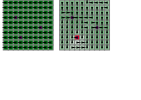

In [97]:
compose(context(), (context(0.,0.,0.4,0.5) , ctx1), (context(0.4,0.,0.4,0.5) , ctx2))

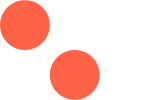

In [79]:
composition = compose(context(0.,0.,10cm,10cm), fill("tomato"),
        (context(0.0, 0.0, 0.5, 0.5), circle()),
        (context(0.5, 0.5, 0.5, 0.5), circle()))

Measures.BoundingBox{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}},Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}((0.0w, 0.0h), (1.0w, 1.0h))

In [39]:
mdp = SimpleGridWorld(size=(10,10), terminate_from=Set([]), tprob=0.7);

In [40]:
pmdp = ProductMDP(mdp, dra, Set{ProductState{GWPos, Int64}}(), ProductState(GWPos(-1,-1), -1))
mecs = maximal_end_components(pmdp, verbose=true)
println("Found " , length(mecs), " MECs of lengths ", [length(mec) for mec in mecs])
mec_list = collect(mecs)
big_mec = Set([states(pmdp)[i] for i in mec_list[1]])
accepting_states!(pmdp)
for s in pmdp.accepting_states
    println(s)
end

Building graph from mdp ... 

Computing Maximal End Components ... 

finished 1 step, old MEC 1 -> new MEC 4
finished 2 step, old MEC 4 -> new MEC 4
finished 3 step, old MEC 4 -> new MEC 4
finished 4 step, old MEC 4 -> new MEC 6
finished 5 step, old MEC 6 -> new MEC 6
finished 6 step, old MEC 6 -> new MEC 5
finished 7 step, old MEC 5 -> new MEC 6
finished 8 step, old MEC 6 -> new MEC 8
finished 9 step, old MEC 8 -> new MEC 7
finished 10 step, old MEC 7 -> new MEC 7
finished 11 step, old MEC 7 -> new MEC 5
finished 12 step, old MEC 5 -> new MEC 5
finished 13 step, old MEC 5 -> new MEC 5
finished 14 step, old MEC 5 -> new MEC 3
finished 15 step, old MEC 3 -> new MEC 3
MECs computed. 

Found 3 MECs of lengths [1, 1, 1]


In [41]:
pol = solve(ValueIterationSolver(verbose=true, max_iterations=31), pmdp)
policy = ModelCheckingPolicy(pol, pmdp, 4);

[Iteration 1   ] residual:          0 | iteration runtime:     69.162 ms, (    0.0692 s total)


automata initial state: 3


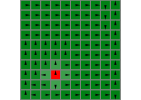

In [33]:
POMDPModelChecking.reset_memory!(policy)
println("automata initial state: ", policy.memory)
POMDPModels.render(mdp, Dict(), valuecolor=s->value(policy, s), action=s->action(policy, s))

In [295]:
policy.memory = 3
value(policy, GWPos(7,1))
action(policy, GWPos(10,1))

:up

In [220]:
transition(pmdp, ProductState(GWPos(1,1), 2), :right)

SparseCat{Array{ProductState{SArray{Tuple{2},Int64,1,2},Int64},1},Array{Float64,1}}(ProductState{SArray{Tuple{2},Int64,1,2},Int64}[ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 1), ProductState{SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 1)], [0.2, 0.1, 0.7])

In [221]:
nextstate(pmdp.automata, 2, labels(mdp, GWPos(1,1), :up))

1

In [207]:
props(pmdp.automata.transition, Edge(2,1))

UndefVarError: UndefVarError: Edge not defined

In [124]:
for s in states(pmdp)
    for a in actions(pmdp)
        d = transition(pmdp, s, a)
        if ProductState(GWPos(1,1), 2) ∈ support(d)
            println(" reachable from state ", s, " by taking action ", a)
        end
    end
end

In [113]:
big_mec = Set([states(pmdp)[i] for i in mec_list[2]])
for s in big_mec
    println(s)
end

ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([2, 1], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([1, 1], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([1, 2], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([2, 2], 2)


In [36]:
POMDPModelChecking.reset_memory!(policy)
rng = MersenneTwister(1)
hr = HistoryRecorder(rng=rng, max_steps=100)
@show s0 = initialstate(mdp, rng)
hist = simulate(hr, mdp, policy, s0)
hsab = collect(eachstep(hist, "s, a, sp"))
for step=1:n_steps(hist)
    s, a, sp = hsab[step]
    @show s
    @show a 
    @show sp
    @show labels(mdp, s, a)
#     POMDPModels.render(mdp, Dict(:s=>s), color=s->value(policy, s))
end

s0 = initialstate(mdp, rng) = [3, 8]
s = [3, 8]
a = :right
sp = [3, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [3, 9]
a = :right
sp = [4, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [4, 9]
a = :right
sp = [3, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [3, 9]
a = :right
sp = [4, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [4, 9]
a = :right
sp = [5, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [5, 9]
a = :right
sp = [4, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [4, 9]
a = :right
sp = [5, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [5, 9]
a = :right
sp = [6, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [6, 9]
a = :right
sp = [7, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [7, 9]
a = :right
sp = [8, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [8, 9]
a = :right
sp = [9, 9]
labels(mdp, s, a) = ()
policy.memory = 1
s = [9, 9]
a = :down
sp = [9, 8]
labels(mdp, s, a) = ()
policy.memory = 1
s = [9, 8]
a = :down
sp = [9, 7]
labels(mdp, s, a) = ()
policy.m

In [ ]:
using Interact
hr = HistoryRecorder(rng=MersenneTwister(1), max_steps=100)
s0 = GWPos(1,10)
hist = simulate(hr, mdp, policy, s0)
hsab = collect(eachstep(hist, "s, a, sp"))
@manipulate for step=1:n_steps(hist)
    s, a, sp = hsab[step]
    POMDPModels.render(mdp, Dict(:s=>s), color=s->colormap(s))
#     @printf("action: %s, observation: %s\n", a, o)
end

In [140]:
s0 ∈ pmdp.accepting_states

true

In [42]:
big_mec = Set([states(pmdp)[i] for i in mec_list[1]])
sum(s.q for s in big_mec if s.q == 1)

99

In [53]:
n_states(pmdp)

16

In [52]:
Set([states(pmdp)[i] for i in mec_list[4]])

Set(ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}[ProductState{SArray{Tuple{2},Int64,1,2},Int64}([-1, -1], -1)])

In [43]:
for s in states(pmdp)
    for a in actions(pmdp)
        d = transition(pmdp, s, a)
        if ProductState(GWPos(8,1), 1) ∈ support(d)
            println(" reachable from state ", s, " by taking action ", a)
        end
    end
end

 reachable from state ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 1) by taking action right
 reachable from state ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([7, 1], 3) by taking action right
 reachable from state ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 1) by taking action down
 reachable from state ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 3) by taking action down
 reachable from state ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 1) by taking action left
 reachable from state ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([9, 1], 3) by taking action left
 reachable from state ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 1) by taking action down
 reachable from state ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([8, 2], 3) by taking action down


In [234]:
accepting_states!(pmdp)
println("Found ", length(pmdp.accepting_states), " accepting states")
for s in pmdp.accepting_states
    println(s)
end
s_acc = collect(pmdp.accepting_states)[1]
stateindex(pmdp, s_acc)

Found 100 accepting states
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([2, 3], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([6, 10], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([5, 6], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([6, 7], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([6, 2], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([10, 6], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([4, 8], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([9, 9], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([2, 5], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([7, 10], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([1, 7], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([2, 7], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([8, 10], 2)
ProductState{StaticArrays.SArray{Tuple{2},Int6

44

In [55]:
discount(pmdp::typeof(pmdp)) = 1.0
pol = solve(ValueIterationSolver(verbose=true), pmdp)
policy = ModelCheckingPolicy(pol, pmdp, 1)

[Iteration 1   ] residual:          0 | iteration runtime:     38.538 ms, (    0.0385 s total)


ModelCheckingPolicy{ValueIterationPolicy{Float64},ProductMDP{StaticArrays.SArray{Tuple{2},Int64,1,2},Symbol,Int64,DeterministicRabinAutomata},Int64}(ValueIterationPolicy{Float64}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Symbol[:up, :down, :left, :right], true, ProductMDP{StaticArrays.SArray{Tuple{2},Int64,1,2},Symbol,Int64,DeterministicRabinAutomata}(SimpleGridWorld
  size: Tuple{Int64,Int64}
  rewards: Dict{StaticArrays.SArray{Tuple{2},Int64,1,2},Float64}
  terminate_from: Set{StaticArrays.SArray{Tuple{2},Int64,1,2}}
  tprob: Float64 0.7
  discount: Float64 0.95
, DeterministicRabinAutomata(3, 1:3, {3, 8} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), Symbol[:b, :a], Tuple{Set{Int64},Set{Int64}}[(Set([]), Set([3]))]), Set(ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}[])

In [249]:
a = findfirst(x-> 1. > x> 0., policy.policy.util)
# states(pmdp)[1]

In [207]:
inf_fin_sets = get_rabin_acceptance(dra)

1-element Array{Tuple{Set{Int64},Set{Int64}},1}:
 (Set([]), Set([2]))

## Solve task using any Value Based Method

In [232]:
solver = ModelCheckingSolver(property=surveillance,
                             solver = ValueIterationSolver(verbose=true),
                             verbose=true)
policy = solve(solver, mdp);

Building graph from mdp ... 

Computing Maximal End Components ... 

finished 1 step, old MEC 1 -> new MEC 3
finished 2 step, old MEC 3 -> new MEC 3
MECs computed. 

Extracting accepting states from MECs ... 

Accepting states computed. 

Found 1 accepting states
[Iteration 1   ] residual:          1 | iteration runtime:     22.073 ms, (    0.0221 s total)
[Iteration 2   ] residual:          0 | iteration runtime:     18.734 ms, (    0.0408 s total)


In [237]:
si = argmax(policy.policy.util)
states(pmdp)[si]

ProductState{StaticArrays.SArray{Tuple{2},Int64,1,2},Int64}([8, 1], 1)

In [67]:
using Interact
hr = HistoryRecorder(rng=MersenneTwister(1), max_steps=500)
s0 = GWPos(1,10)
POMDPModelChecking.reset_memory!(policy)
hist = simulate(hr, mdp, policy, s0)
hsab = collect(eachstep(hist, "s, a, sp"))
@manipulate for step=1:n_steps(hist)
    s, a, sp = hsab[step]
    POMDPModels.render(mdp, Dict(:s=>s), color=s->colormap(s))
#     @printf("action: %s, observation: %s\n", a, o)
end

┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/Interact/XmYW4.ji for Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1184


HTML{String}("    <script id=\"webio-setup-8332362554147478540\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-2735607523873756708\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-8332362554147478540\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/9cca5546f29c7adda98d68be0fe62b817752b58f-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/9cca5546f29c7adda98d68be0fe62b817752b58f-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-2735607523873756708\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

MethodError: MethodError: no method matching reset_memory!(::ValueIterationPolicy{Float64})
Closest candidates are:
  reset_memory!(!Matched::ModelCheckingPolicy) at /mnt/c/Users/Maxime/wsl/.julia/dev/POMDPModelChecking/src/model_checking_solver.jl:65

In [41]:
function colormap(s)
    if s == GWPos(2,2)
        return 0.
    elseif s == GWPos(8, 2)
        return 10.
    elseif s == GWPos(1, 4)
        return 0.
    elseif s == GWPos(4,3)
        return 0.
    else
        return 0.
    end
end

colormap (generic function with 1 method)